In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
img_generator = ImageDataGenerator(
    brightness_range=(0.5,1),
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale = 1./255,
    validation_split=0.3
)

In [18]:
root_dir = "datasets/object_detection/caltech-101-img"

img_generator_flow_train = img_generator.flow_from_directory(
    directory = root_dir,
    target_size = (224, 224),
    batch_size = 32,
    shuffle =True,
    subset = "training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory = root_dir,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    subset = "validation")

Found 6445 images belonging to 102 classes.
Found 2700 images belonging to 102 classes.


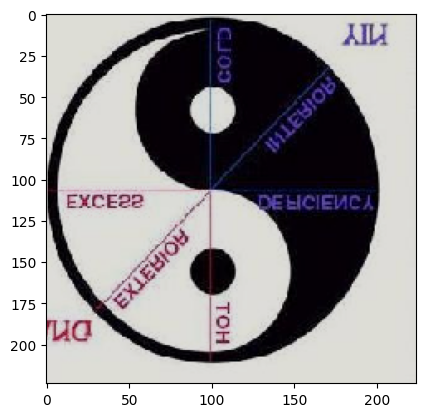

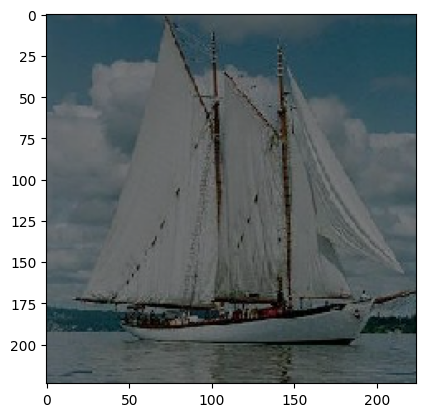

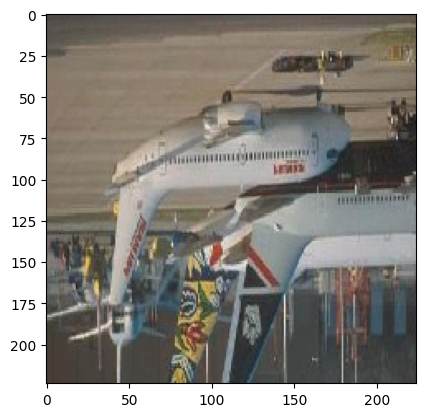

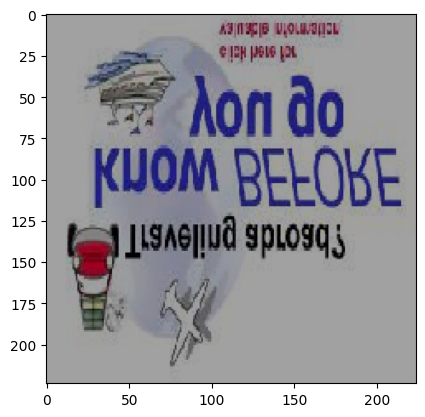

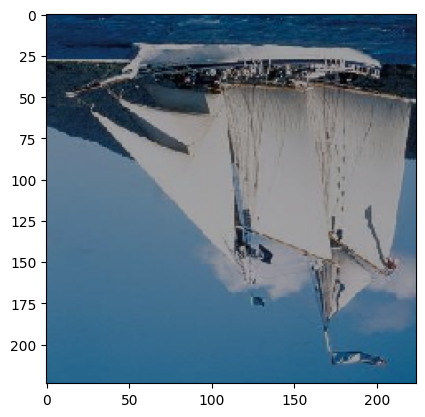

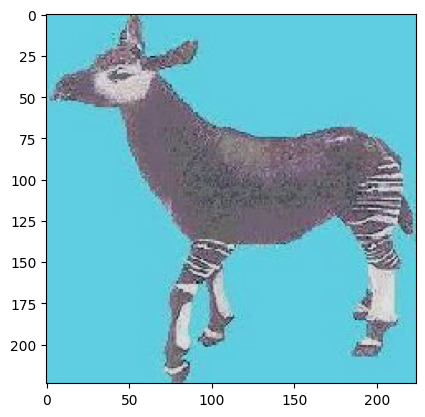

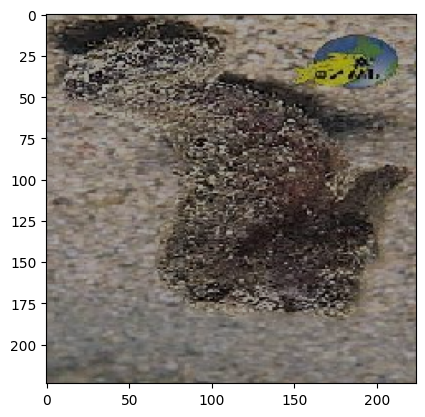

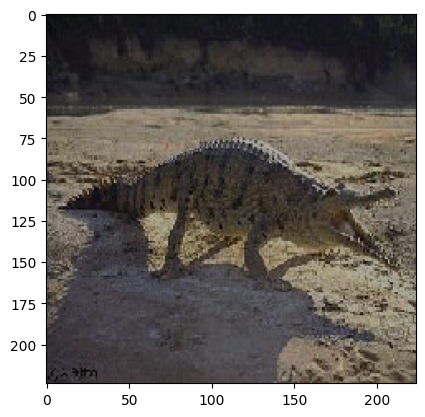

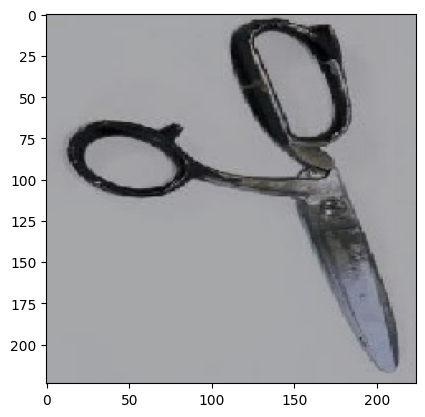

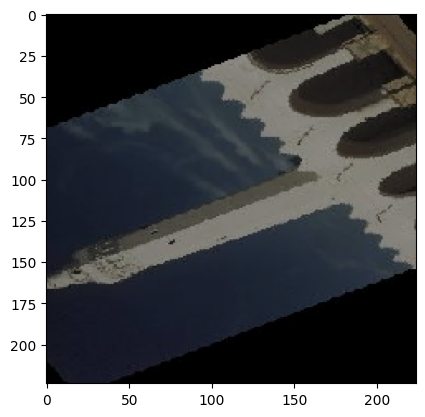

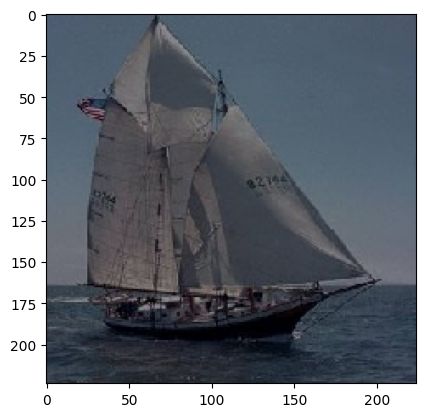

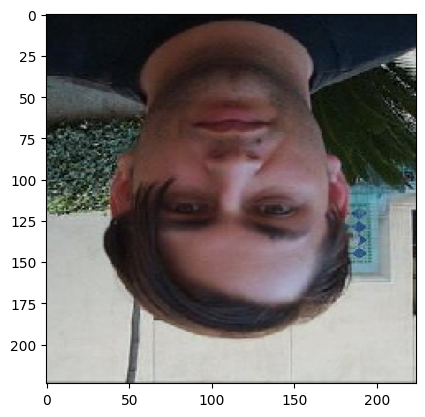

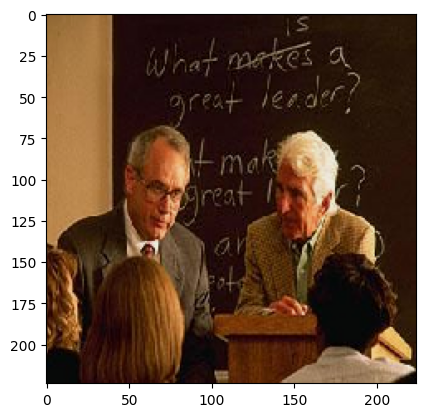

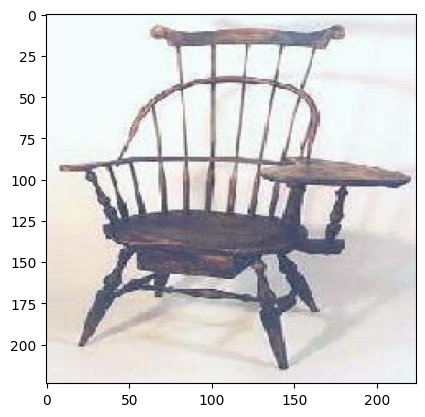

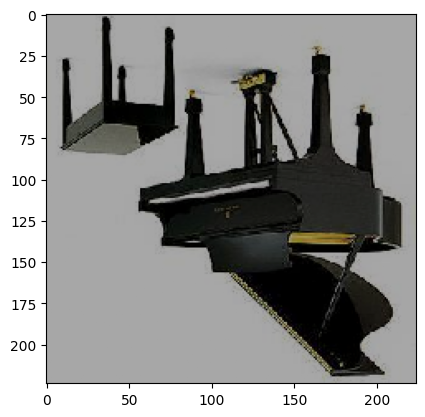

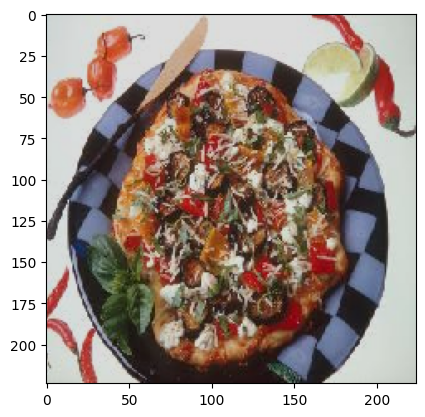

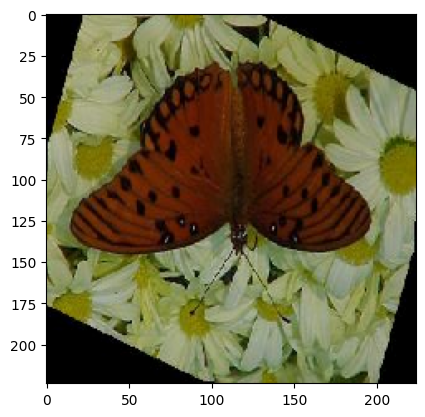

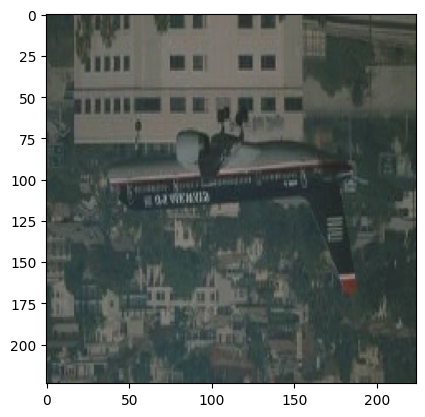

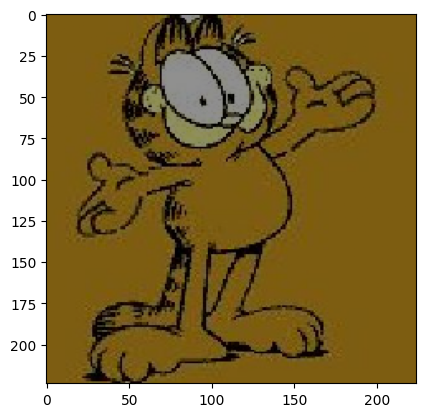

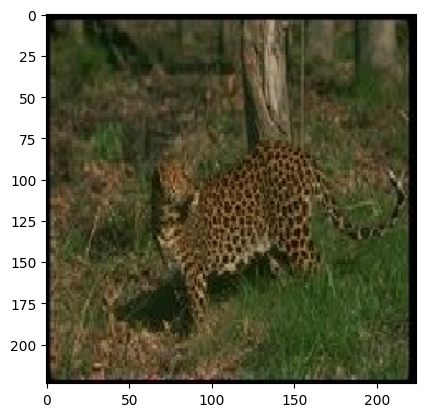

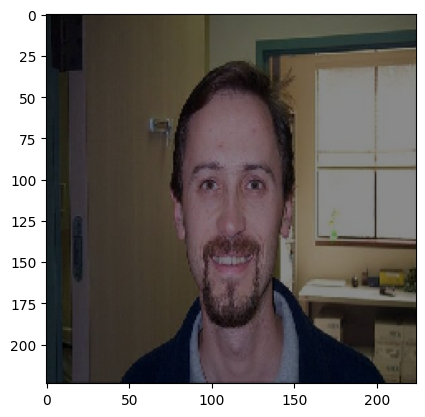

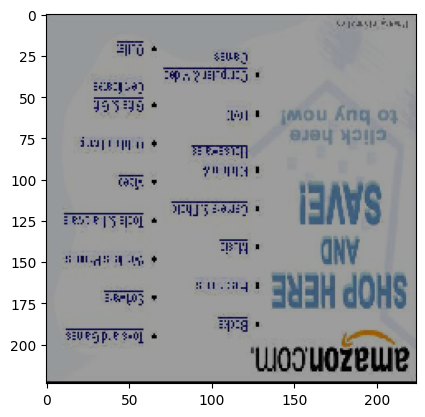

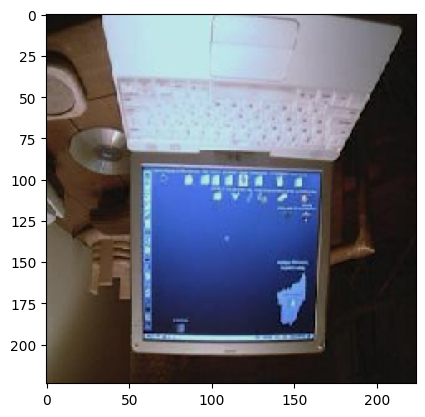

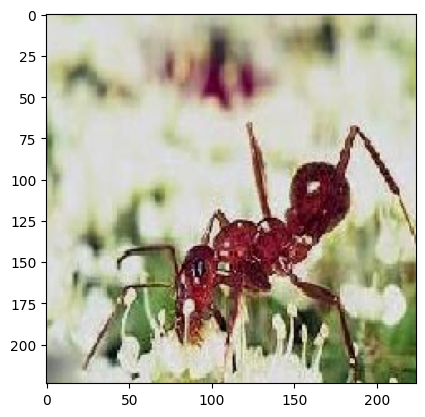

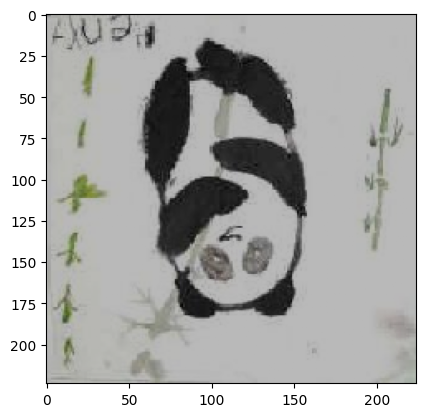

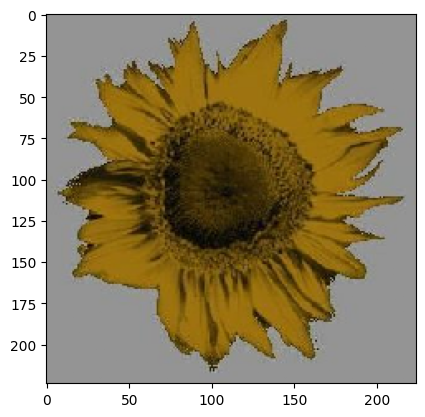

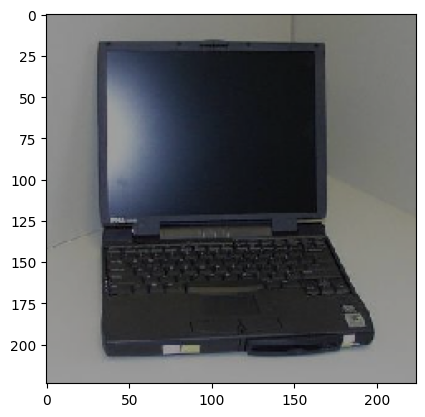

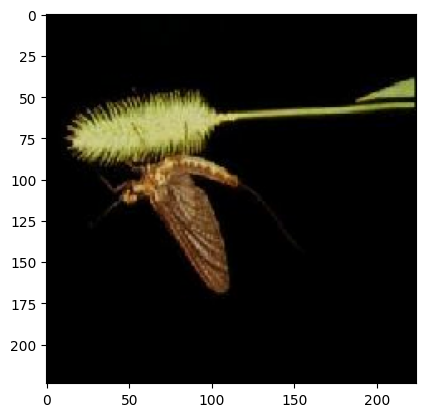

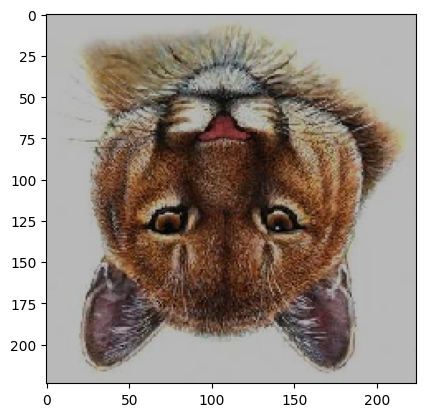

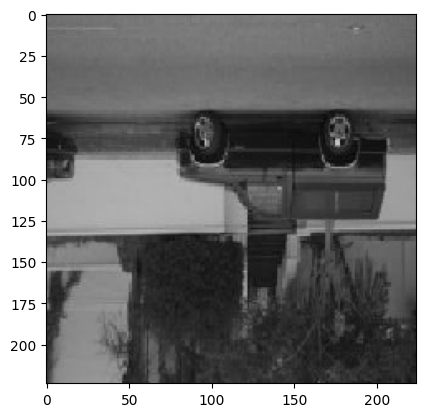

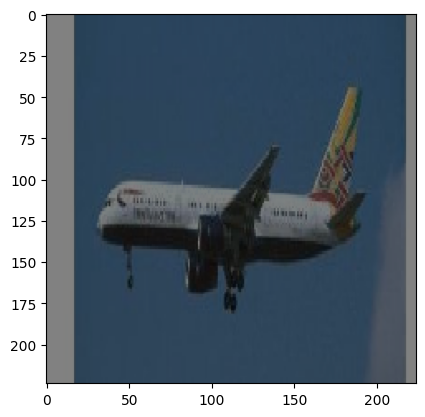

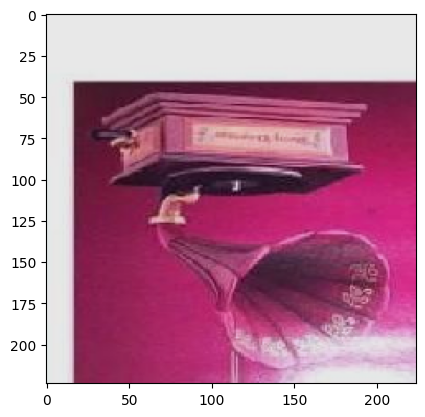

In [19]:
imgs, labels = next(iter(img_generator_flow_train))
for img, labels in zip(imgs, labels):
    plt.imshow(img)
    plt.show()

In [20]:
def infinite_generator(generator):
    while True:
        for data in generator:
            yield data

train_infinite = infinite_generator(img_generator_flow_train)

In [21]:
model_path = "datasets/object_detection/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

base_model = VGG16(input_shape=(224, 224, 3),
                   include_top = False, 
                   weights = model_path)

In [22]:
base_model.trainable = False

In [23]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(102, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │         470,118 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,184,806 (57.93 MB)

 Trainable params: 470,118 (1.79 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train only 5 steps per epoch ---
model.fit(
    train_infinite,
    validation_data=img_generator_flow_valid,
    steps_per_epoch=5,   # only 5 batches per epoch
    epochs=10
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 216s 53s/step - accuracy: 0.0514 - loss: 4.8578 - val_accuracy: 0.1815 - val_loss: 4.8137
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 212s 52s/step - accuracy: 0.2325 - loss: 4.6714 - val_accuracy: 0.2485 - val_loss: 4.3619
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 211s 52s/step - accuracy: 0.2619 - loss: 4.0984 - val_accuracy: 0.2830 - val_loss: 3.8114
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 210s 52s/step - accuracy: 0.2710 - loss: 3.9761 - val_accuracy: 0.3511 - val_loss: 3.3787
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 212s 52s/step - accuracy: 0.3455 - loss: 3.4640 - val_accuracy: 0.3848 - val_loss: 3.0842
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 212s 52s/step - accuracy: 0.3688 - loss: 2.9925 - val_accuracy: 0.4044 - val_loss: 2.9339
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 213s 53s/step - accuracy: 0.3689 - loss: 3.0234 - val_accuracy: 0.4626 - val_loss: 2.6559
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 214s 53s/step - accuracy: 0.4225 - loss: 2.7635 - val_accuracy: 0.4511 - val_loss:

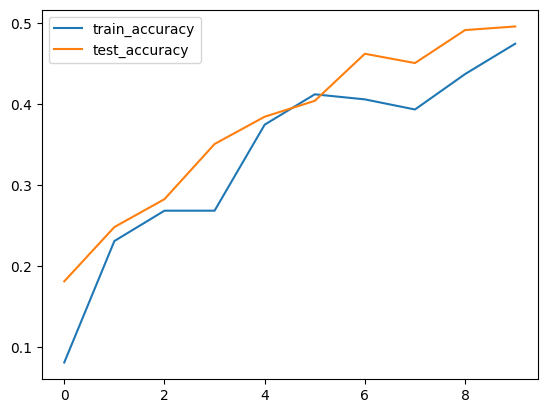

In [27]:
plt.plot(model.history.history['accuracy'], label='train_accuracy')
plt.plot(model.history.history['val_accuracy'],label='test_accuracy')
plt.legend()

In [31]:
base_model.trainable = True
for layer in base_model.layers[:-4]:  # freeze first layers, unfreeze last 4
    layer.trainable = False


model.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer=Adam(1e-5))

In [33]:
history_finetune = model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, 
          steps_per_epoch=5, 
          epochs=10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 618s 152s/step - categorical_accuracy: 0.0849 - loss: 4.2141 - val_categorical_accuracy: 0.0889 - val_loss: 4.2187
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 260s 63s/step - categorical_accuracy: 0.0286 - loss: 4.2999 - val_categorical_accuracy: 0.0889 - val_loss: 4.2165
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 206s 51s/step - categorical_accuracy: 0.0655 - loss: 4.1460 - val_categorical_accuracy: 0.0889 - val_loss: 4.2147
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 211s 52s/step - categorical_accuracy: 0.0723 - loss: 4.2746 - val_categorical_accuracy: 0.0889 - val_loss: 4.2130
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 213s 52s/step - categorical_accuracy: 0.0811 - loss: 4.2633 - val_categorical_accuracy: 0.0889 - val_loss: 4.2121
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 211s 52s/step - categorical_accuracy: 0.0497 - loss: 4.4147 - val_categorical_accuracy: 0.0889 - val_loss: 4.2099
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 213s 53s/step - categorical_accuracy: 0.0894 - loss: 4.1985 - v

In [37]:
print(history_finetune.history.keys())

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


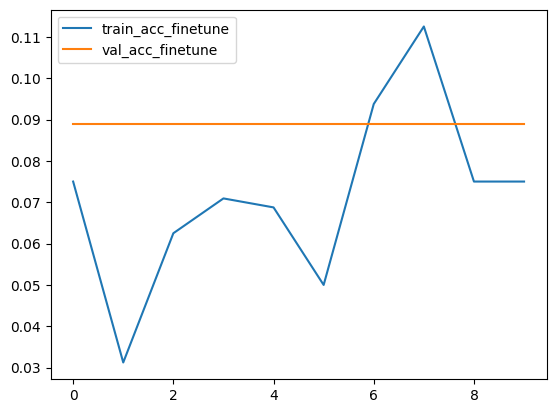

In [39]:
#plt.plot(history.history['accuracy'], label='train_acc_initial')
#plt.plot(history.history['val_accuracy'], label='val_acc_initial')
plt.plot(history_finetune.history['categorical_accuracy'], label='train_acc_finetune')
plt.plot(history_finetune.history['val_categorical_accuracy'], label='val_acc_finetune')
plt.legend()
plt.show()